In [57]:
import re
import numpy as np
import pandas as pd
import pickle
from io import BytesIO
import base64

from PIL import Image
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional imports for features
try:
    from bs4 import BeautifulSoup
except ImportError:
    BeautifulSoup = None
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    SentenceTransformer = None
try:
    import torch
    from torchvision import models, transforms
except ImportError:
    torch = models = transforms = None

In [58]:
# --- Text preprocessing ---
def decode_html_entities(text: str) -> str:
    if not text:
        return ""
    def replace_entity(m):
        try:
            return chr(int(m.group(1)))
        except (ValueError, OverflowError):
            return m.group(0)
    return re.sub(r"&#(\d+);", replace_entity, str(text))

def strip_html(text: str) -> str:
    if not text:
        return ""
    if BeautifulSoup is not None:
        return BeautifulSoup(str(text), "html.parser").get_text(separator=" ")
    return re.sub(r"<[^>]+>", " ", str(text))

def preprocess_text(text: str) -> str:
    if pd.isna(text) or text == "":
        return ""
    t = decode_html_entities(str(text))
    t = strip_html(t)
    return " ".join(t.split())

In [59]:
# --- Text feature engineering ---
def count_emoji_entities(text: str) -> int:
    if not text:
        return 0
    return len(re.findall(r"&#\d+;", str(text)))

def extract_text_features(series: pd.Series) -> np.ndarray:
    rows = []
    for t in series:
        t = "" if pd.isna(t) else str(t)
        text_len = len(t)
        word_count = len(t.split()) if t else 0
        emoji_count = count_emoji_entities(t)
        has_links = 1.0 if ("http" in t or "www." in t) else 0.0
        br_count = t.lower().count("<br>") + t.lower().count("<br/>") + t.lower().count("<br />")
        clean = preprocess_text(t)
        html_clean_len = len(clean)
        rows.append([text_len, word_count, emoji_count, has_links, br_count, html_clean_len])
    return np.array(rows, dtype=np.float64)

In [60]:
# --- Image feature engineering ---
def img_vectorizer(photo_base64: str) -> np.ndarray:
    try:
        img = np.array(Image.open(BytesIO(base64.b64decode(photo_base64))))
    except Exception:
        return np.zeros(22, dtype=np.float64)
    s = img.shape
    if len(s) == 2:
        img = np.stack([img, img, img], axis=-1)
    h, w = s[0], s[1]
    img = img.reshape(-1, 3)
    aspect_ratio = w / h if h > 0 else 0.0
    pixel_count = h * w
    stats = [
        np.array([h, w], dtype=np.float64),
        np.array([aspect_ratio, pixel_count], dtype=np.float64),
        img.min(axis=0).astype(np.float64),
        img.max(axis=0).astype(np.float64),
        img.mean(axis=0), img.std(axis=0), np.median(img, axis=0),
    ]
    cm = np.corrcoef(img.T)
    if np.any(np.isnan(cm)):
        cm = np.zeros((3, 3))
    stats.append(cm[np.triu_indices(len(cm), k=1)].astype(np.float64))
    return np.concatenate(stats)

def extract_img_features(photo_series: pd.Series) -> np.ndarray:
    return np.vstack(list(photo_series.map(img_vectorizer)))

In [61]:
# --- Text embeddings ---
def get_text_embeddings(texts: pd.Series, model_name="paraphrase-multilingual-MiniLM-L12-v2", model=None):
    if SentenceTransformer is None:
        raise ImportError("sentence-transformers required. pip install sentence-transformers")
    if model is None:
        model = SentenceTransformer(model_name)
    cleaned = texts.fillna("").astype(str).map(preprocess_text)
    emb = model.encode(cleaned.tolist(), show_progress_bar=len(cleaned) > 1000)
    return np.array(emb, dtype=np.float64), model

In [62]:
# --- Image embeddings ---
def _get_image_transform():
    if transforms is None:
        raise ImportError("torchvision required")
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def _base64_to_tensor(photo_base64: str):
    try:
        img = Image.open(BytesIO(base64.b64decode(photo_base64))).convert("RGB")
    except Exception:
        return None
    return _get_image_transform()(img)

def get_image_embeddings(photo_series: pd.Series, model=None, batch_size=32, device='cpu'):
    if torch is None or models is None:
        raise ImportError("torch and torchvision required")
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    if model is None:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = torch.nn.Identity()
        model.eval()
        model.to(device)
    tensors = []
    for p in photo_series:
        t = _base64_to_tensor(p)
        if t is None:
            t = torch.zeros(3, 224, 224)
        tensors.append(t)
    stack = torch.stack(tensors).to(device)
    embs = []
    with torch.no_grad():
        for i in range(0, len(stack), batch_size):
            out = model(stack[i:i+batch_size])
            embs.append(out.cpu().numpy())
    return np.vstack(embs).astype(np.float64), model

In [63]:
# --- Load saved artifacts ---
def load_text_embedder(path="text_embedder"):
    if SentenceTransformer is None:
        raise ImportError("sentence-transformers required")
    return SentenceTransformer(path)

def load_image_backbone(path="image_backbone.pt"):
    if torch is None or models is None:
        raise ImportError("torch and torchvision required")
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Identity()
    ckpt = torch.load(path, map_location="cpu")
    model.load_state_dict(ckpt["state_dict"], strict=True)
    model.eval()
    return model

In [64]:
# --- Combined pipeline ---
def build_features(df, text_embedder=None, image_backbone=None, text_embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
                   use_text_embeddings=True, use_text_handcrafted=True, use_image_embeddings=True, use_image_handcrafted=True):
    parts = []
    artifacts = {}
    if use_text_embeddings and SentenceTransformer is not None:
        texts = df["text"].fillna("")
        X_te, model = get_text_embeddings(texts, model_name=text_embedding_model, model=text_embedder)
        parts.append(X_te)
        artifacts["text_embedder"] = model
    if use_text_handcrafted:
        parts.append(extract_text_features(df["text"]))
    if use_image_embeddings and torch is not None:
        X_ie, backbone = get_image_embeddings(df["photo"], model=image_backbone)
        parts.append(X_ie)
        artifacts["image_backbone"] = backbone
    if use_image_handcrafted:
        parts.append(extract_img_features(df["photo"]))
    return np.hstack(parts), artifacts

In [65]:
train = pd.read_csv("data/train.csv")

In [66]:
train["text"] = train["text"].fillna("")

In [67]:
train.loc[5374].text

'&#10024;Как хрупка жизнь&#33; Как ценны минуты, которые нам дарят радость общения&#33; Как важно общаться, пока мы живы&#33; Ведь и жизнь в Царстве Божием будет жизнью в общении с Богом и святыми Его.<br>Не часто ли мы видим вокруг, что смерть собирает больше людей, чем радостные поводы? Многочисленные родственники скорее съедутся на смерть или поминки, чем на день рождения. Пока человек жив, кажется: еще столько времени впереди. Успеем и встретиться, и поговорить, и прочее… Но наступает момент, когда уже ничего не успеешь. Ничего не добавишь.<br>Успевайте общаться. Говорить друг другу добро. Пусть ваши родные и близкие знают, что они дороги вам, что вы их любите.&#128105;&#8205;&#128105;&#8205;&#128103;&#8205;&#128103;<br><br>&#128214;Священник Андрей Дудченко<br><br>&#10067;Что думаете? Расскажите&#128073;'

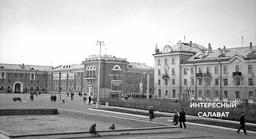

In [68]:
Image.open(BytesIO(base64.b64decode(train.loc[12366].photo)))

In [69]:
# Build features: text embeddings + handcrafted text + image embeddings + handcrafted image
X, artifacts = build_features(
    train,
    use_text_embeddings=True,
    use_text_handcrafted=True,
    use_image_embeddings=False,
    use_image_handcrafted=False,
)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 777.99it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s]


In [70]:
# Save artifacts (only those that were created)
if "text_embedder" in artifacts:
    artifacts["text_embedder"].save("text_embedder")
if "image_backbone" in artifacts:
    import torch
    torch.save({"state_dict": artifacts["image_backbone"].state_dict()}, "image_backbone.pt") 

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


In [71]:
# X already built above
print("Feature shape:", X.shape)

Feature shape: (20000, 390)


In [72]:
# Artifacts saved above

In [73]:
target = ["like", "comment", "hide", "expand", "open_photo", "open", "share_to_message"]

In [74]:
# Train/val split (80/20)
train_idx, val_idx = train_test_split(np.arange(len(train)), test_size=0.2, random_state=42)
X_train, X_val = X[train_idx], X[val_idx]

In [80]:
model = {}
from tqdm import tqdm
for column in tqdm(target):
    reg = CatBoostRegressor(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=0,
    )
    y = train[column] / train['view']
    y_train = y.iloc[train_idx].values
    reg.fit(X_train, y_train)
    model[column] = reg

100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


In [81]:
# Validation metrics
y_val = {col: (train[col] / train['view']).iloc[val_idx].values for col in target}
metrics_rows = []
for col in target:
    pred = model[col].predict(X_val)
    y_true = y_val[col]
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    metrics_rows.append({"target": col, "RMSE": rmse, "MAE": mae, "R²": r2})
metrics_df = pd.DataFrame(metrics_rows).set_index("target")
print("Validation metrics (engagement rate):\n")
print(metrics_df.round(6).to_string())

Validation metrics (engagement rate):

                      RMSE       MAE        R²
target                                        
like              0.028501  0.018585  0.176927
comment           0.002149  0.000790  0.096478
hide              0.001344  0.000557  0.008468
expand            0.044679  0.020727  0.556783
open_photo        0.055303  0.035445  0.064158
open              0.036002  0.018816  0.420571
share_to_message  0.003864  0.002319  0.072434


In [ ]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)